In [ ]:
# from scipy.sparse import csr_matrix

### Входные данные

#### Загрузка

In [ ]:
# !unzip capstone_user_identification.zip

In [1]:
# from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import pickle

In [2]:
PATH_TO_DATA = '../capstone_user_identification'
# PATH_TO_DATA = '../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2'

times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id', parse_dates=times)
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id', parse_dates=times)
df_train.shape, df_test.shape

((253561, 21), (82797, 20))

In [3]:
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

Словарь сайтов

In [5]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    site2id  = pickle.load(f)
id2site = {v:k for (k, v) in site2id.items()}
id2site[0] = 'unknown'

### Обработка

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import numpy as np

In [7]:
df_train.sort_values(by='time1', inplace=True)

In [8]:
class DataPreparator(BaseEstimator, TransformerMixin):
    """
    Fill NaN with zero values;
    No: Prepare a (Count)Vectorizer friendly 2D-list from data;
    No: Site ids to names.
    """
    def __init__(self, id2site):
        super().__init__()
        self.id2site = id2site
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sites = ['site%s' % i for i in range(1, 11)]
        # Convert dataframe rows to strings
        return X[sites].fillna(0).astype('int')#.apply(lambda row: ' '.join([self.id2site[i] for i in row]), axis=1).tolist()

In [9]:
class ListPreparator(BaseEstimator, TransformerMixin):
    """
    Prepare a CountVectorizer friendly 2D-list from data.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.values.tolist()
        # Convert dataframe rows to strings
        return [" ".join([str(site) for site in row]) for row in X]

In [72]:
vectorizer_pipeline = Pipeline([
    ("preparator", DataPreparator(id2site)),
    ("list_preparator", ListPreparator()),
    ("vectorizer", CountVectorizer(ngram_range=(1, 2), max_features=20000))  # tokenizer=lambda s: s.split()
#     ("vectorizer", TfidfVectorizer(ngram_range=(1, 3)))
])

In [73]:
%%time
X_train_vectorized = vectorizer_pipeline.fit_transform(df_train)
X_train_vectorized

CPU times: user 5.55 s, sys: 18.8 ms, total: 5.57 s
Wall time: 5.57 s


<253561x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2498250 stored elements in Compressed Sparse Row format>

In [13]:
y_train = df_train["target"].astype('int').values

Опции:
- CountVectorizer ngram_range max_features
    - (1, 1)
        - max-k: 0.8530563468012738, 0.08925871896536618
    - (1, 2)
        - max-k: 0.8577666221636842, 0.09371826647019514
        - 50000: 0.858414628277273, 0.09308624515067462
        - 20000: 0.8600043484189314, 0.0901820258132247
    - (1, 3)
        - max-k: 0.8560039171386127, 0.09631952839070929
- TfidfVectorizer ngram_range max_features
    - (1, 1)
        - max-k: 0.8391530980059445, 0.08120401396593267
    - (1, 2)
        - max-k: 0.8294502665752119, 0.08421253009084147
    - (1, 3)
        - max-k: 0.8230380243367905, 0.08660127058036823

Выбираем CountVectorizer(ngram_range=(1, 2), max_features=20000)

### Feature engineering

In [93]:
from scipy.sparse import hstack
import seaborn as sns
from matplotlib import pyplot as plt

In [22]:
feature_names = ['morning', 'day', 'evening', 'weekday', 'year', 'session_duration']
# + list(calendar.day_name)

Рассмотрим признаки:
- Дата
    - час начала сессии
        - утро
        - день
        - вечер
        - ночь
        - циклические координаты (sin|cos часа)
    - месяц
        - сезон
    - год
        - год + месяц
    - день
        - выходной / будний
        - dummies
        - is_monday...
    - длина сессии
        - длина посещений каждого сайта
- Сайт
    - число уникальных сайтов в сессии (сколько повторов за сессию)
    - факт посещения абсолютно уникальных сайтов
    - факт посещения сайтов из топ-10 популярных сайтов
    - посещение определённых сайтов (facebook итд)

In [83]:
time_features = pd.DataFrame()

In [79]:
df_train_times = df_train[times]

In [187]:
def feature_hist(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    if time_features[feature].dtype == 'int':
        sns.countplot(time_features[feature], ax=ax1)
        sns.countplot(time_features[y_train == 1][feature], ax=ax2)
    elif time_features[feature].dtype == 'float':
        sns.histplot(time_features[feature], ax=ax1)
        sns.histplot(time_features[y_train == 1][feature], ax=ax2)
    ax1.set_title('All')
    ax2.set_title('Target');

#### Час

In [85]:
time_features['hour'] = df_train_times['time1'].apply(lambda ts: ts.hour)

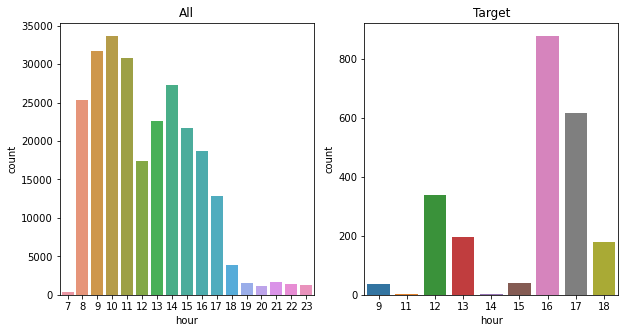

In [188]:
feature_hist('hour')

#### Месяц

In [103]:
time_features['month'] = df_train_times['time1'].apply(lambda ts: ts.month)

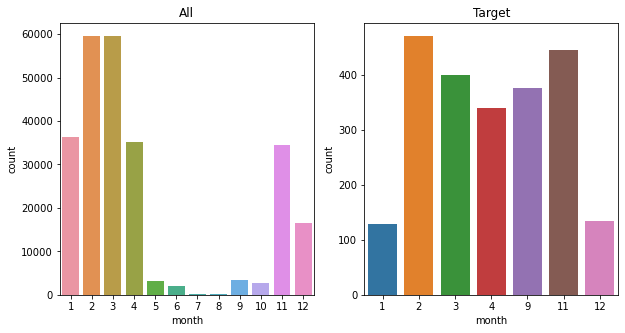

In [117]:
feature_hist('month')

#### Год

In [109]:
time_features['year'] = df_train_times['time1'].apply(lambda ts: ts.year)

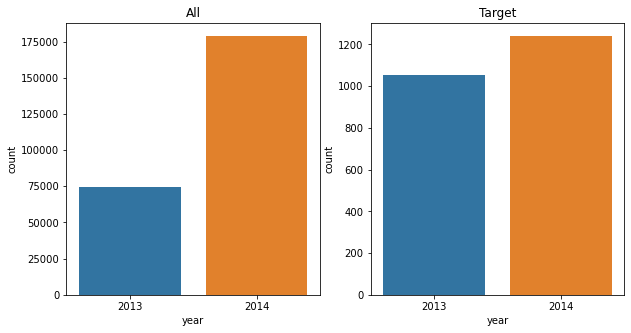

In [119]:
feature_hist('year')

#### День недели

In [123]:
time_features['day'] = df_train_times['time1'].apply(lambda ts: ts.weekday())

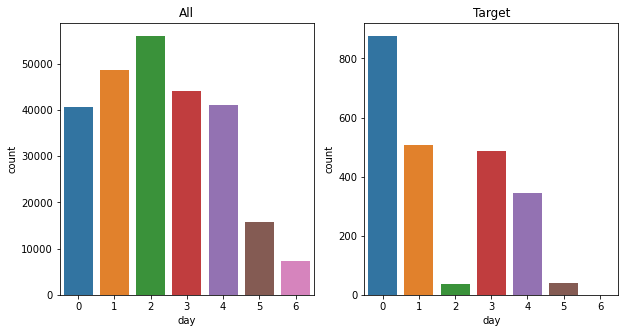

In [125]:
feature_hist('day')

#### Длина сессии

In [175]:
time_features['duration'] = df_train_times.apply(lambda row: \
                                                 (row.max() - row.min()).total_seconds(), axis=1)

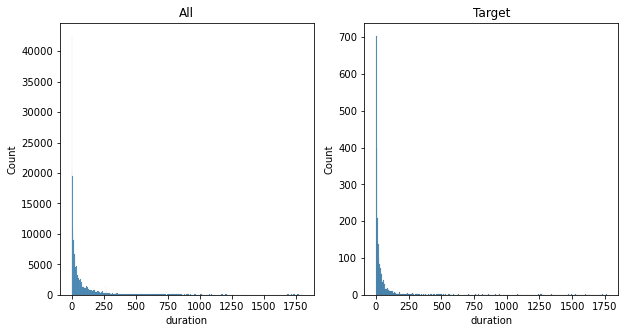

In [189]:
feature_hist('duration')

===============================

In [16]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new attributes to training and test set.
    """ 
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        # intraday features
        hour = X['time1'].apply(lambda ts: ts.hour)#.values
        morning = ((hour >= 7) & (hour <= 11)).astype('int')#.reshape(-1, 1)
        day = ((hour >= 12) & (hour <= 18)).astype('int')
        evening = ((hour >= 19) & (hour <= 23)).astype('int')
        night = ((hour >= 0) & (hour <= 6)).astype('int')
        
        # season features
        month = X['time1'].apply(lambda ts: ts.month)
        summer = ((month >= 6) & (month <= 8)).astype('int')
        
        # day of the week features
        weekday = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
        #     is_monday = np.isin(weekday, [0])
        #     is_wednesday = np.isin(weekday, [2])
        #     is_sunday = np.isin(weekday, [6])
        #     is_weekend = np.isin(weekday, [0, 2, 6])
        #     weekdays = pd.get_dummies(weekday.flatten()).to_numpy().reshape(7, -1, 1)
        
        # year features
#         year = X['time1'].apply(lambda ts: ts.year).astype('int') / 1e3
        year_month = X['time1'].apply(lambda t: 100 * t.year + t.month) / 1e5
        
        X = np.c_[morning.values, day.values, evening.values, weekday.values, year_month.values]

        return X

In [17]:
class ScaledAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new features, that should be scaled.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # session time features
        times = ['time%s' % i for i in range(1, 11)]
        sites = ['site%s' % i for i in range(1, 11)]
        
        # session duration: take to the power of 1/5 to normalize the distribution
        session_duration = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) #** 0.2
        
        # number of sites visited in a session
        number_of_sites = X[times].isnull().sum(axis=1).apply(lambda x: 10 - x)
        
        # average time spent on one site during a session
        time_per_site = (session_duration / number_of_sites) #** 0.2
        
#         unique_sites = X[sites].apply(lambda sites: sites.nunique(), axis=1)
        
        X = np.c_[session_duration.values]
        return X

In [18]:
attributes_pipeline = Pipeline([
    ("adder", AttributesAdder())
])

scaled_attributes_pipeline = Pipeline([
    ("adder", ScaledAttributesAdder()),
    ("scaler", StandardScaler())
])

feature_pipeline = FeatureUnion(transformer_list=[
    ('attributes_pipeline', attributes_pipeline),
    ('scaled_attributes_pipeline', scaled_attributes_pipeline)
])

In [19]:
%%time
X_train_features = feature_pipeline.fit_transform(df_train)

CPU times: user 4.33 s, sys: 121 ms, total: 4.45 s
Wall time: 4.36 s


In [20]:
X_train = hstack([X_train_vectorized, X_train_features])
X_train

<253561x50006 sparse matrix of type '<class 'numpy.float64'>'
	with 4353284 stored elements in COOrdinate format>

=========================================

In [23]:
pd.DataFrame(X_train_features, columns=feature_names)

,morning,day,evening,weekday,year,session_duration
0,1.0,0.0,0.0,5.0,2.01301,-0.468233
1,1.0,0.0,0.0,5.0,2.01301,5.570015
2,1.0,0.0,0.0,5.0,2.01301,-0.454709
3,1.0,0.0,0.0,5.0,2.01301,-0.458090
4,1.0,0.0,0.0,5.0,2.01301,-0.461471
...,...,...,...,...,...,...
253556,0.0,0.0,1.0,2.0,2.01404,-0.427662
253557,0.0,0.0,1.0,2.0,2.01404,0.133564
253558,0.0,0.0,1.0,2.0,2.01404,-0.373568
253559,0.0,0.0,1.0,2.0,2.01404,-0.207905


### Модель

In [24]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

#### Обучение и подбор гиперпараметров

In [25]:
model = SGDClassifier(loss='log', random_state=2179, n_jobs=-1)
time_split = TimeSeriesSplit(n_splits=10)

In [131]:
# grid = {
#     'penalty': ['l2'],
#     'alpha': np.linspace(3e-05, 5e-05, 11)
# }

In [132]:
# %%time

# search = GridSearchCV(model, param_grid=grid, cv=time_split, scoring='roc_auc')
# search.fit(X_train, y_train)

CPU times: user 3min 35s, sys: 3.52 s, total: 3min 38s
Wall time: 55.1 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=SGDClassifier(loss='log', n_jobs=-1, random_state=2179),
             param_grid={'alpha': array([3.0e-05, 3.2e-05, 3.4e-05, 3.6e-05, 3.8e-05, 4.0e-05, 4.2e-05,
       4.4e-05, 4.6e-05, 4.8e-05, 5.0e-05]),
                         'penalty': ['l2']},
             scoring='roc_auc')

In [133]:
# search.best_params_, search.best_score_

({'alpha': 3e-05, 'penalty': 'l2'}, 0.9202566766880926)

=======================================================

In [68]:
%%time

# sites = ['site%s' % i for i in range(1, 11)]

cv_scores = cross_val_score(model, X_train_vectorized, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

CPU times: user 50.5 ms, sys: 61.5 ms, total: 112 ms
Wall time: 1.34 s


In [69]:
cv_scores, cv_scores.mean(), cv_scores.std()

(array([0.72812538, 0.60716968, 0.83211273, 0.88283075, 0.79727575,
        0.86652885, 0.88896047, 0.87248392, 0.86217578, 0.89271694]),
 0.8230380243367905,
 0.08660127058036823)

0.9197500019625826

0.9315069358401142,
 0.044345068769381366 0 2 6

0.9180564468510812,
 0.05889198351691508 baseline

0.9232962337585114,
 0.058257317090901546

0.9287111177172779,
 0.04434090003756869 2

### Тест

In [138]:
import eli5
import calendar

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                               
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [139]:
%%time
X_test_vectorized = vectorizer_pipeline.transform(df_test)
X_test_features = feature_pipeline.transform(df_test)
X_test = hstack([X_test_vectorized, X_test_features])

X_test

CPU times: user 4.16 s, sys: 9.95 ms, total: 4.17 s
Wall time: 4.16 s


<82797x50005 sparse matrix of type '<class 'numpy.float64'>'
	with 1251012 stored elements in COOrdinate format>

In [140]:
search.best_estimator_.fit(X_train, y_train)
logit_test_pred_proba = search.best_estimator_.predict_proba(X_test)

In [146]:
# pd.DataFrame({'feature': feature_names, 'coef': search.best_estimator_.coef_.flatten()[-len(feature_names):]})

In [109]:
eli5.show_weights(estimator=search.best_estimator_, feature_names=vectorizer_pipeline['vectorizer'].get_feature_names() \
                  + feature_names, top=30)

Weight?,Feature
+1.434,cid-ed6c3e6a5c6608a4.users.storage.live.com
+1.397,day
+1.287,youwatch.org
+1.181,www.express.co.uk
+1.048,vk.com
+0.953,media-1.melty.fr
+0.942,fr.glee.wikia.com
+0.934,www.banque-chalus.fr
+0.887,www.video.tt
+0.879,www.audienceinsights.net


In [147]:
write_to_submission_file(logit_test_pred_proba[:, 1], 'result.csv')